# **Supervised learning**

In this notebook, I will apply Supervised Learning (Regression) on a Retail Dataset.

### Objective

The goal here is to take a messy retail dataset and see if we can use math to predict how much a customer is likely to spend in the future. It’s basically moving from "what happened in the past" to "what might happen next."

## Let's download dataset

In [17]:
# !wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx"

## Let's explore the data

Before touching anything, I needed to see what I was working with. I loaded the data and ran some basic checks to see the column names, look at the first few rows, and check for missing information. It’s like checking the ingredients before you start cooking—you need to know if anything is missing.

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [19]:
df = pd.read_excel("online_retail_II.xlsx")

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [21]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [22]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,525461.000000,525461,525461.000000,417534.000000
mean,10.337667,2010-06-28 11:37:36.845017856,4.688834,15360.645478
min,-9600.000000,2009-12-01 07:45:00,-53594.360000,12346.000000
25%,1.000000,2010-03-21 12:20:00,1.250000,13983.000000
50%,3.000000,2010-07-06 09:51:00,2.100000,15311.000000
75%,10.000000,2010-10-15 12:45:00,4.210000,16799.000000
max,19152.000000,2010-12-09 20:01:00,25111.090000,18287.000000
std,107.424110,NaN,146.126914,1680.811316


In [23]:
df.isnull().sum()

,0
Invoice,0
StockCode,0
Description,2928
Quantity,0
InvoiceDate,0
Price,0
Customer ID,107927
Country,0


## Data Cleaning

Real-world data is almost always "dirty." I spent time here removing rows that didn't have a Customer ID and filtering out "negative" transactions (which are usually returns or errors). I also wrote a custom function to trim away extreme outliers—those rare, massive orders that don't represent a "normal" customer—so they wouldn't confuse the machine learning model later on.

In [24]:
def remove_outliers(df, column):
    df = df[df[column] > 0]
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_boundary = Q1 - 1.5 * IQR
    upper_boundary = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_boundary) & (df[column] <= upper_boundary)]

In [25]:
df.drop('Description', axis=1, inplace=True, errors='ignore')
df = df.dropna(subset=['Customer ID'])

df = df[(df['Quantity'] > 0) & (df['Price'] > 0)].copy()

df['TotalPrice'] = df['Quantity'] * df['Price']

df = remove_outliers(df, 'Quantity')
df = remove_outliers(df, 'Price')

print(f"Data points after cleaning: {len(df)}")

Data points after cleaning: 348613


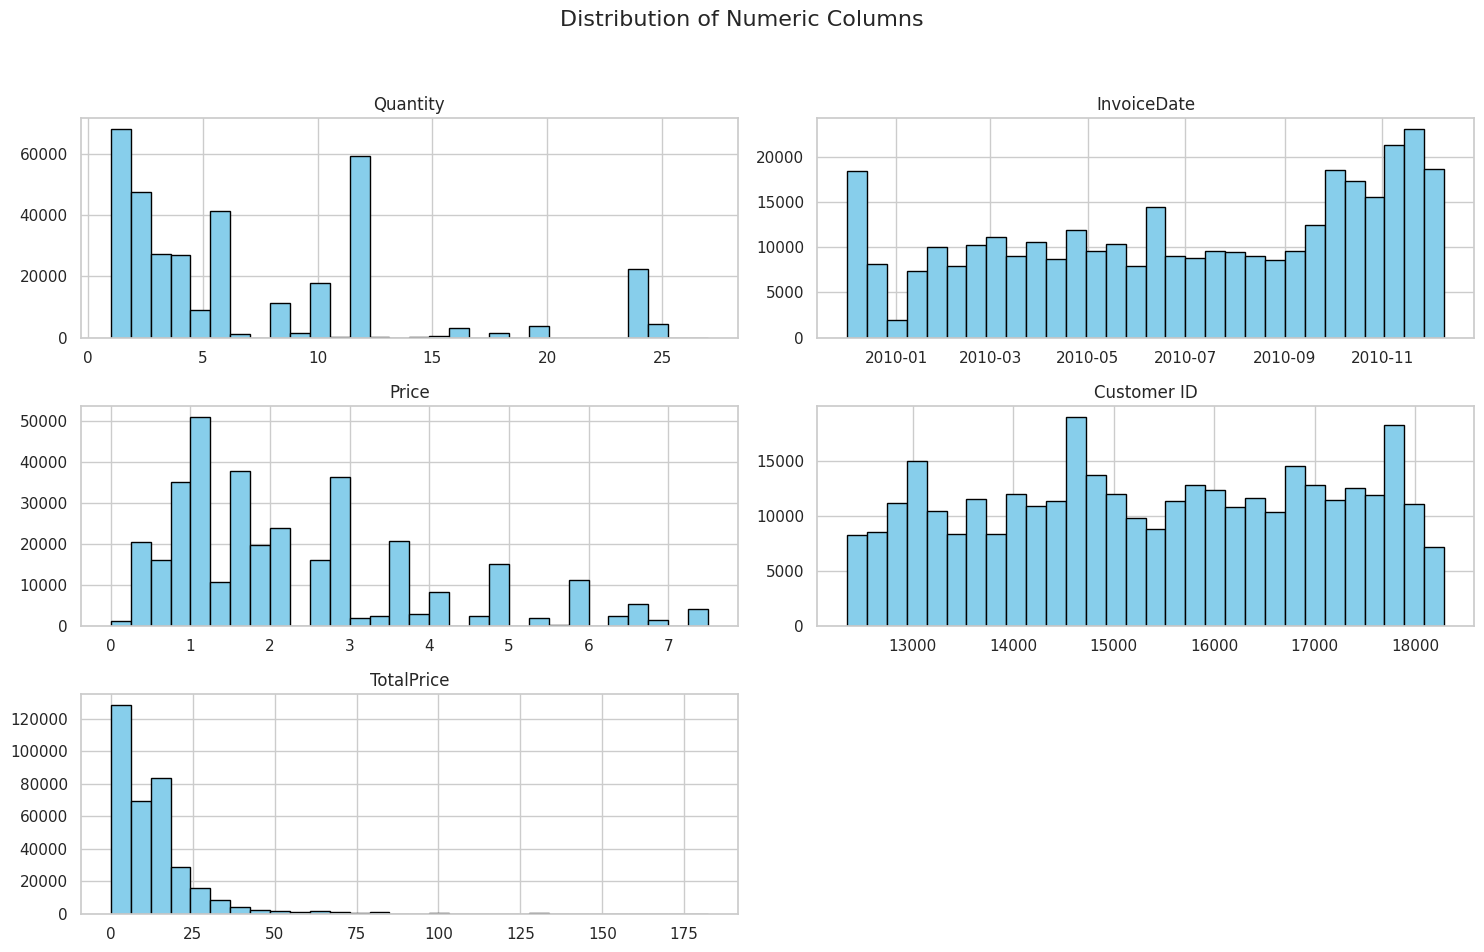

In [26]:
sns.set(style="whitegrid")

df.hist(bins=30, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle('Distribution of Numeric Columns', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Feature Engineering

This is where the magic happens. A model can't just read a list of a thousand receipts; it needs a summary. I split the data by date and calculated three key metrics for every customer: how recently they shopped (Recency), how often they shop (Frequency), and how much they’ve spent in total (Monetary). These "RFM" scores are the signals I'll use to predict their future spending.

In [27]:
split_date = df['InvoiceDate'].max() - pd.Timedelta(days=90)

past_df = df[df['InvoiceDate'] < split_date]
rfm = past_df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (split_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()
rfm.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary']

future_df = df[df['InvoiceDate'] >= split_date]
target_spend = future_df.groupby('Customer ID')['TotalPrice'].sum().reset_index()
target_spend.columns = ['Customer ID', 'Target_Spend']

rfm = pd.merge(rfm, target_spend, on='Customer ID', how='left')
rfm['Target_Spend'] = rfm['Target_Spend'].fillna(0)

rfm['Target_Spend'] = rfm['Target_Spend'].clip(lower=0)
rfm['Monetary'] = rfm['Monetary'].clip(lower=0)

## EDA (Exploratory Data Analysis)

I took a pause here to visualize the data. I looked at the distribution of spending and checked how the different features related to each other using a heatmap. I noticed the spending data was very skewed (a few people spend a lot, most spend a little), so I decided to use a "log transformation" to smooth those numbers out, making it easier for the model to learn the patterns.

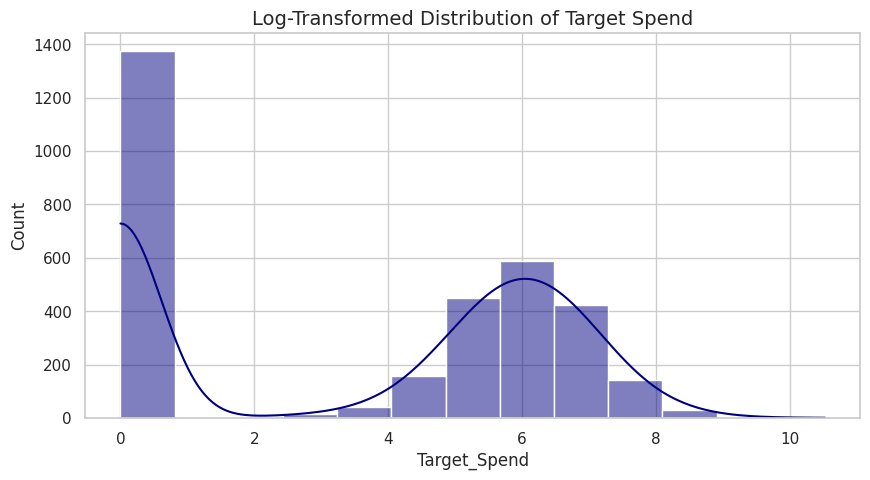

In [28]:
plt.figure(figsize=(10, 5))
sns.histplot(np.log1p(rfm['Target_Spend']), kde=True, color='navy')
plt.title('Log-Transformed Distribution of Target Spend', fontsize=14)
plt.show()

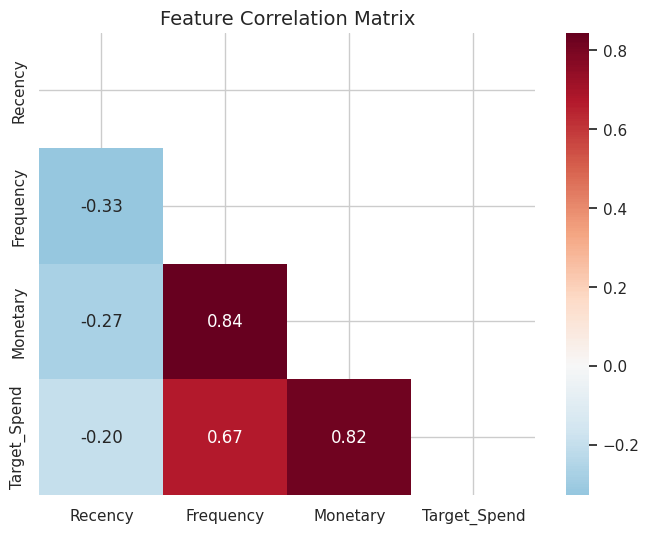

In [29]:
plt.figure(figsize=(8, 6))
corr = rfm[['Recency', 'Frequency', 'Monetary', 'Target_Spend']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, cmap='RdBu_r', center=0, fmt=".2f")
plt.title('Feature Correlation Matrix', fontsize=14)
plt.show()

## Model Training and Evaluation

This is the core "Supervised Learning" part. I took my prepared features and fed them into three different types of models—a simple Linear Regression, a Random Forest, and a powerful XGBoost. I split the data so the models would learn on one portion and then be "tested" on a portion they hadn't seen before. This tells me how well the model will actually perform in the real world.

In [30]:
rfm = remove_outliers(rfm, 'Monetary')
rfm = remove_outliers(rfm, 'Target_Spend')

rfm = rfm[rfm['Monetary'] > 0].copy()

print(f"Customers remaining for modeling: {len(rfm)}")

Customers remaining for modeling: 1516


In [31]:
X = rfm[['Recency', 'Frequency', 'Monetary']]
y = rfm['Target_Spend']
y_log = np.log1p(y)

X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

lr.fit(X_train_scaled, y_train_log)
rf.fit(X_train, y_train_log)
xgb_model.fit(X_train, y_train_log)

lr_preds_log = lr.predict(X_test_scaled)
rf_preds_log = rf.predict(X_test)
xgb_preds_log = xgb_model.predict(X_test)

In [33]:
def get_metrics(y_true_log, y_pred_log, name):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    r2_log = r2_score(y_true_log, y_pred_log)

    print(f"--- {name} ---")
    print(f"MAE: £{mae:.2f}")
    print(f"R2 (Original Scale): {r2:.4f}")
    print(f"R2 (Log Scale): {r2_log:.4f}\n")

get_metrics(y_test_log, lr_preds_log, "Linear Regression")
get_metrics(y_test_log, rf_preds_log, "Random Forest")
get_metrics(y_test_log, xgb_preds_log, "XGBoost")

--- Linear Regression ---
MAE: £199.68
R2 (Original Scale): 0.0977
R2 (Log Scale): 0.1861

--- Random Forest ---
MAE: £213.10
R2 (Original Scale): 0.0221
R2 (Log Scale): 0.0858

--- XGBoost ---
MAE: £209.07
R2 (Original Scale): 0.0320
R2 (Log Scale): 0.0760



## Feature Importance Visualization

I wanted to see "under the hood" of the Random Forest model. I created a chart to show which of my features actually mattered most. It turns out that a customer's past spending habits (Monetary) are usually the biggest clue to what they will spend in the future, which makes a lot of sense intuitively.

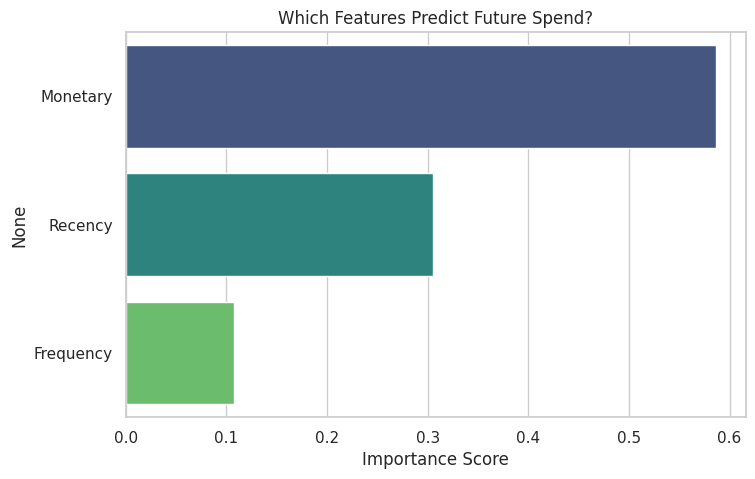

In [34]:
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(
    x=importances.values,
    y=importances.index,
    hue=importances.index,
    palette='viridis',
    legend=False
)

plt.title('Which Features Predict Future Spend?')
plt.xlabel('Importance Score')
plt.show()

## Actual vs. Predicted Visualization

For the final check, I plotted my model's guesses against the actual results. By drawing a diagonal "perfect match" line, I could easily see where the model was spot-on and where it was struggling. It's a great way to visually confirm if the model is reliable or if it's just making wild guesses. Looking at the plot, most of the dots fall below the red line, which tells me the model is being "conservative"—it tends to under-predict the biggest spenders. This usually happens because it's hard to guess a massive shopping spree using only three basic metrics (RFM), so the model plays it safe by guessing closer to the average.

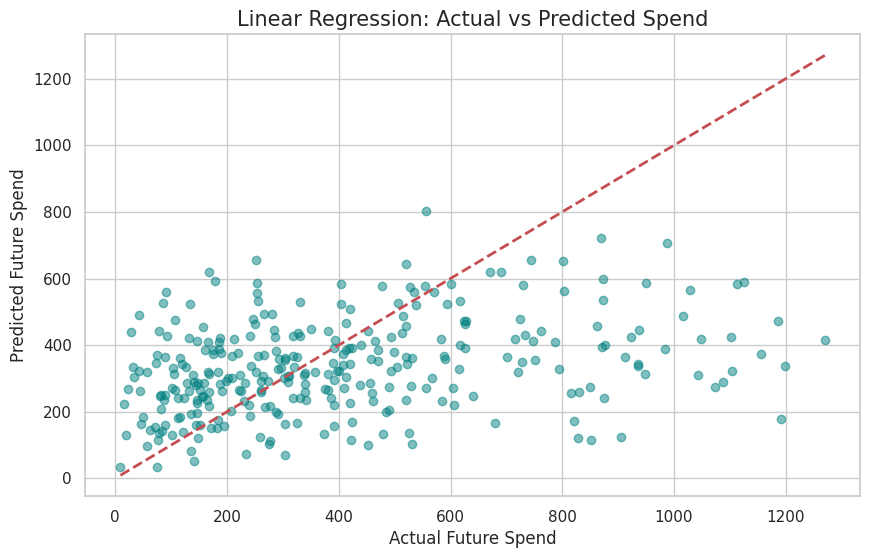

In [36]:
plt.figure(figsize=(10, 6))

y_actual = np.expm1(y_test_log)
y_pred_lr = np.expm1(xgb_preds_log)

plt.scatter(y_actual, y_pred_lr, alpha=0.5, color='teal')
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', lw=2)

plt.title('Linear Regression: Actual vs Predicted Spend', fontsize=15)
plt.xlabel('Actual Future Spend')
plt.ylabel('Predicted Future Spend')
plt.show()

## Final Conclusion

After testing three different models, I found that while predicting the exact pound amount for every customer is difficult—especially since the models tend to be a bit conservative with high-spenders—they are still excellent at distinguishing between high-value and low-value customers. The Monetary feature was by far the biggest clue, proving that past spending is the best predictor of future loyalty. Even if the predictions aren't perfect down to the penny, this tool is incredibly valuable for a business; it allows us to rank customers by importance, helping a marketing team focus their budget on the "VIPs" or win back big spenders before they stop shopping entirely.

## Future Improvements & Feature Expansion

While the RFM features provide a solid foundation, we could likely close the gap between our low predictions and the actual high spenders by adding more "contextual" features. For example, adding Product Diversity (does the customer buy many different items or just one category?), Seasonality (do they only shop during Christmas or Black Friday?), and Discount Sensitivity (do they only buy when there is a coupon?) would give the model a much better understanding of why someone is spending money. By moving beyond just "how much" and "when," and looking at "what" and "how" they buy, we could significantly improve the model's accuracy for high-value shoppers.